In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import AUROC, Accuracy, ConfusionMatrix, F1Score
import os, subprocess, gc, time, datetime
from itertools import product

import models.models_original as models_original
import models.models_3d_atomics as models_3d_atomics
import models.models_3d as models_3d
from vasopressor.preprocess_helpers import load_and_create_MIMIC_dataloader
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import greedy_forward_selection, get_top_features_per_concept

device = get_free_gpu()

current device cuda:14


In [2]:
train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = 1)

print(class_weights, num_classes, seq_len)

for batch in train_loader:
    [print(t.shape, t.device) for t in batch]
    break

len(train_loader)

tensor([0.5797, 3.6376], dtype=torch.float64) 2 6
torch.Size([512, 6, 27]) cpu
torch.Size([512, 6, 27]) cpu
torch.Size([512, 8]) cpu
torch.Size([512, 2]) cpu


35

In [3]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.yscale("log")
    plt.legend()
    plt.show()

def plot_metrics(history, n_concepts_list):
    plt.plot(history[:, 0], history[:, 2], label=f'AUC')
    plt.plot(history[:, 0], history[:, 3], label=f'ACC')
    plt.plot(history[:, 0], history[:, 4], label=f'F1')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title('Plot of Concepts vs Criteria')
    plt.xticks(n_concepts_list)

    plt.legend()
    plt.show()

def plot_atomics_concepts_metric(history, title, dec="{:.3g}"):
        
    df = pd.DataFrame(history, columns=["n_atomics", "n_concepts", "val_loss", "auc", "acc", "f1"])
    mean_atomics = df.groupby("n_atomics").mean()
    mean_concepts = df.groupby("n_concepts").mean()

    # display(mean_atomics)
    plt.plot(mean_atomics.index, mean_atomics["auc"], label='AUC')
    plt.plot(mean_atomics.index, mean_atomics["acc"], label='ACC')
    plt.plot(mean_atomics.index, mean_atomics["f1"], label='F1')
    plt.xlabel('Num Atomics')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over atomics")
    plt.suptitle(title)
    plt.legend()
    plt.show()

    # display(mean_concepts)
    plt.plot(mean_concepts.index, mean_concepts["auc"], label='AUC')
    plt.plot(mean_concepts.index, mean_concepts["acc"], label='ACC')
    plt.plot(mean_concepts.index, mean_concepts["f1"], label='F1')
    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over concepts")
    plt.suptitle(title)
    plt.legend()
    plt.show()


In [4]:
seq_len = seq_len
changing_dim = len(changing_vars)
static_dim = len(static_names)

print(changing_dim, static_dim, seq_len)

random_seed = 1
set_seed(random_seed)


27 8 6


In [5]:
auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)
conf_matrix = ConfusionMatrix(task="binary").to(device)

## Optimization

In [13]:
experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/model3d/"

def get_model_encode_var(random_seed):
    # feature weights
    config = {
        "n_concepts": 4,
        "use_indicators": True,
        "encode_time_dim": False,
    }
    
    makedir(experiment_folder)
    model_path = get_filename_from_dict(experiment_folder, config)

    train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

    model = models_3d.CBM(**config, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2, top_k=None, device=device)
    model.try_load_else_fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config, seed = random_seed), max_epochs=10000)

    evaluate_classification(model, test_loader)
    return model

model = get_model_encode_var(1)


def get_model_encode_time(random_seed):
    # feature weights
    config = {
        "n_concepts": 4,
        "use_indicators": True,
        "encode_time_dim": True,
    }
    
    makedir(experiment_folder)
    model_path = get_filename_from_dict(experiment_folder, config)

    train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

    model = models_3d.CBM(**config, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2, top_k=None, device=device)
    model.try_load_else_fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config, seed = random_seed), max_epochs=10000)

    evaluate_classification(model, test_loader)
    return model

model = get_model_encode_time(1)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/model3d/n_concepts_4_use_indicators_True_encode_time_dim_False_seed_1.pt
AUC macro 0.913
ACC macro 0.840
 F1 macro 0.848


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/model3d/n_concepts_4_use_indicators_True_encode_time_dim_True_seed_1.pt
AUC macro 0.917
ACC macro 0.845
 F1 macro 0.852


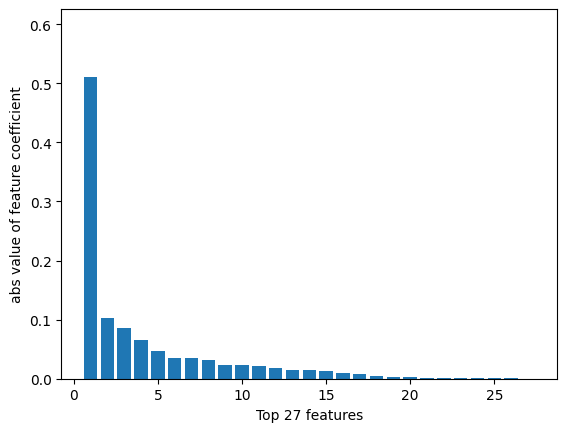

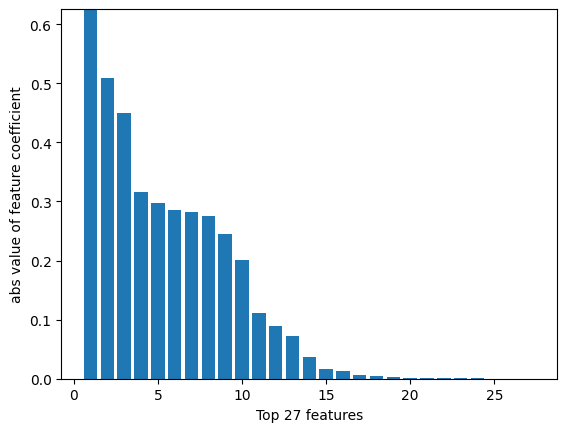

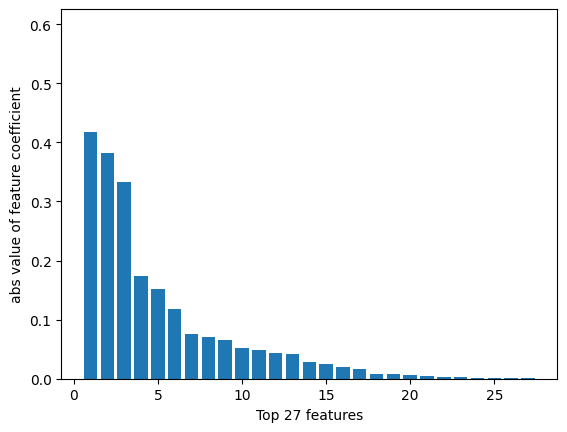

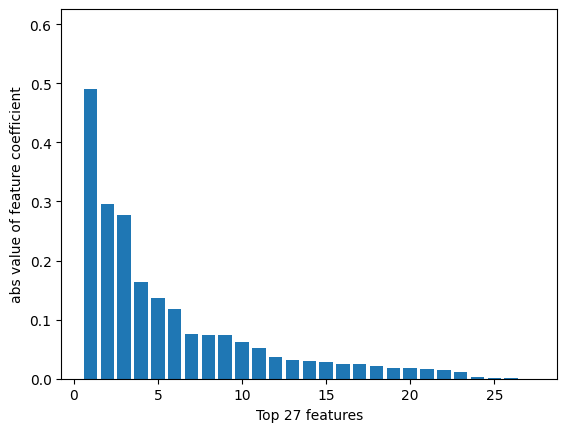

In [11]:
visualize_top100_weights_per_channel(model.bottleneck)


In [ ]:
# write top k inds to csv
top_k_file = experiment_folder + "top-k/top_k_idx.csv"
print(top_k_file)

print(len(top_k_inds))
[print(len(x)) for x in top_k_inds]

df = pd.DataFrame(top_k_inds).T
# write_df_2_csv(top_k_file, df)

# read_df_from_csv()
lists = df.apply(lambda x: x.dropna().tolist()).tolist()
print(len(lists))
[print(len(x)) for x in lists]

# directory = os.path.dirname(top_k_file)
# if not os.path.exists(directory):
#     os.makedirs(directory)

# # writing to csv file 
# with open(top_k_file, 'w') as csvfile: 
#     # creating a csv writer object 
#     csvwriter = csv.writer(csvfile)
#     # writing the data rows 
#     csvwriter.writerows(top_k_inds)


In [29]:
auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)

track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               "auc": auroc_metric,
               }

models = [get_model(seed) for seed in range(1,4)]

results = []
for seed, model in enumerate(models, 1):
    print("seed", seed)
    top_k_inds = get_top_features_per_concept(model.bottleneck)
    
    greedy_results = greedy_forward_selection(model=model, layers_to_prune=[model.bottleneck], top_k_inds=[top_k_inds], val_loader=val_loader, optimize_metric=auroc_metric, device=device, track_metrics=track_metrics)
    greedy_results['Merged'] = greedy_results['Layer'].astype(str) + '_' + greedy_results['Concept'].astype(str) + '_' + greedy_results['Feature'].astype(str)
    results.append(greedy_results)
    
    top_k_csv_file = experiment_folder + "top-k/bottleneck_topkinds_seed_{seed}.csv".format(seed=seed)

    write_df_2_csv(top_k_csv_file, greedy_results)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original_new/n_concepts_4_use_indicators_True_use_only_last_timestep_False_seed_1.pt
AUC macro 0.9131898880004883
ACC macro 0.8352497220039368
 F1 macro 0.8434697389602661


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original_new/n_concepts_4_use_indicators_True_use_only_last_timestep_False_seed_2.pt
AUC macro 0.9151526093482971
ACC macro 0.8385961651802063
 F1 macro 0.846611738204956


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original_new/n_concepts_4_use_indicators_True_use_only_last_timestep_False_seed_3.pt
AUC macro 0.9143695831298828
ACC macro 0.8337909579277039
 F1 macro 0.8420966863632202
1
2
Found 4 Concepts
90th percentile per concept [7.7694016 1.8362296 3.104334  7.6339426]
['Concept 0 len: 80', 'Concept 1 len: 146', 'Concept 2 len: 122', 'Concept 3 len: 83']


100%|██████████| 40/40 [2:05:51<00:00, 188.80s/it, Score=0.92628, acc=0.864, f1=0.868, auc=0.926]  


3
Found 4 Concepts
90th percentile per concept [ 0.689293  7.083639 10.341766  1.816546]
['Concept 0 len: 297', 'Concept 1 len: 62', 'Concept 2 len: 108', 'Concept 3 len: 140']


100%|██████████| 40/40 [3:16:09<00:00, 294.23s/it, Score=0.92914, acc=0.86, f1=0.867, auc=0.929]   


In [52]:

def plot_selected_weights(weight, greedy_results):
    abs_weight = weight.detach().cpu().numpy()
    abs_weight = np.abs(abs_weight)
    
    n_concepts = abs_weight.shape[0]
    max_y = np.max(abs_weight)
    
    fig, axs = plt.subplots(n_concepts, figsize=(8, 2 * n_concepts))
    
    for c in range(n_concepts):
        ax = axs[c]
        
        inds = np.argsort(-abs_weight[c])[:100]
        
        selected_features = greedy_results[greedy_results["Concept"] == c]["Feature"].to_list()
        colors = ['red' if i in selected_features else 'gray' for i in inds]
        ax.bar(np.arange(1, 101), abs_weight[c][inds], color=colors)
        
        ax.set_title(f"Concept {c + 1}")
        # ax.set_xlabel("Top 100 features")
        # ax.set_ylabel("abs value of feature coefficient")
        ax.set_ylim(0, max_y)
        ax.set_yscale('log')
        
        ax.legend(['Selected', 'Not Selected'])
    
    plt.xlabel("Top 100 features")
    plt.ylabel("abs value of feature coefficient")
    plt.tight_layout()
    plt.show()



In [20]:
models = [get_model(i) for i in range(1,4)]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/model3d/n_concepts_4_use_indicators_True_encode_time_dim_False_seed_1.pt
AUC macro 0.9126362800598145
ACC macro 0.8398833274841309
 F1 macro 0.8479465246200562


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  0%|          | 2/10000 [00:01<2:35:23,  1.07 epoch/s, Train Loss=0.62038, Val Loss=0.62227, Best Val Loss=0.62227]

 11%|█         | 1090/10000 [17:44<2:24:59,  1.02 epoch/s, Train Loss=0.47626, Val Loss=0.49628, Best Val Loss=0.49478]

Early Stopped


AUC macro 0.9194375276565552
ACC macro 0.8446027040481567
 F1 macro 0.8515938520431519


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  5%|▌         | 530/10000 [07:37<2:16:08,  1.16 epoch/s, Train Loss=0.48340, Val Loss=0.49649, Best Val Loss=0.49610]

Early Stopped


AUC macro 0.9190932512283325
ACC macro 0.8443452715873718
 F1 macro 0.8512626886367798


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/model3d/n_concepts_4_use_indicators_True_encode_time_dim_True_seed_1.pt
AUC macro 0.917
ACC macro 0.845
 F1 macro 0.852
AUC macro 0.914
ACC macro 0.838
 F1 macro 0.845
AUC macro 0.917
ACC macro 0.845
 F1 macro 0.852
AUC macro 0.917
ACC macro 0.866
 F1 macro 0.870


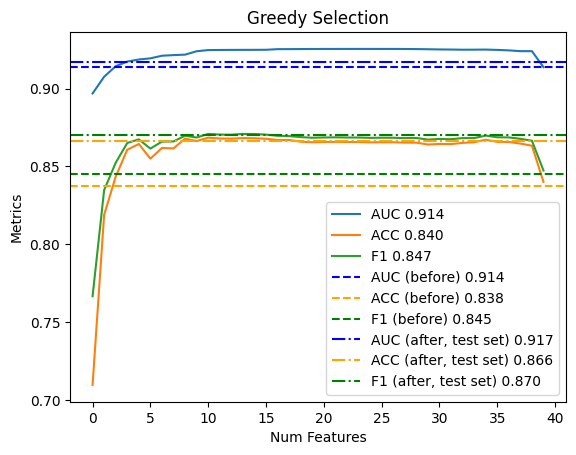

In [14]:
model = get_model_encode_time(1)
greedy_results = read_df_from_csv("/workdir/optimal-summaries-public/_models/vasopressor/model3d/top-k/bottleneck_topkinds_encode_time_dim_True_1.csv")

train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

visualize_optimization_results(model, val_loader, test_loader, greedy_results)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/model3d/n_concepts_4_use_indicators_True_encode_time_dim_False_seed_1.pt
AUC macro 0.913
ACC macro 0.840
 F1 macro 0.848
AUC macro 0.912
ACC macro 0.836
 F1 macro 0.843
AUC macro 0.913
ACC macro 0.840
 F1 macro 0.848
AUC macro 0.926
ACC macro 0.862
 F1 macro 0.867


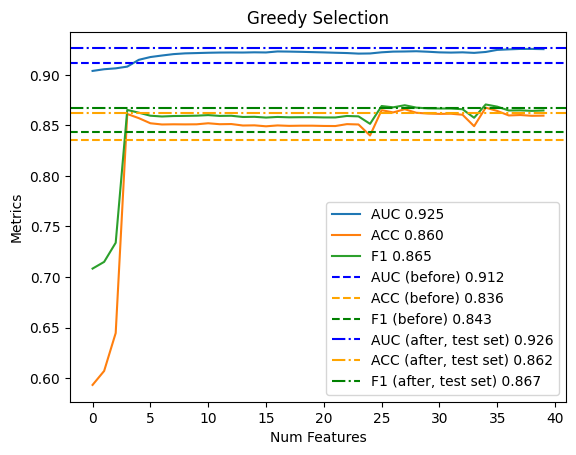

In [15]:
model = get_model_encode_var(1)
greedy_results = read_df_from_csv("/workdir/optimal-summaries-public/_models/vasopressor/model3d/top-k/bottleneck_topkinds_encode_time_dim_False_1.csv")

train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

visualize_optimization_results(model, val_loader, test_loader, greedy_results)
